> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- This NB is based off of NB107.  
- May want to log, save, and write all the decs from NBs 201/202.  
- Not sure whether it is worth testing on all conditions (e.g. to generate more training data for this adversarial model). I did so since there were so few instances of each class in the training data otherwise.  Well really each update doesn't matter only the user so maybe I didn't need to do that   
- Also should save the models from earlier NBs (102, 104, 106, 107) and see how they perform on this data
- Plot adversarial accuracy wrt each local iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *
from fl_sim_classes import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

## Load Data

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

In [3]:
with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

cond1b1_dict_list = [0]*num_participants
cond2b1_dict_list = [0]*num_participants
cond3b1_dict_list = [0]*num_participants
cond4b1_dict_list = [0]*num_participants
#cond5b1_dict_list = [0]*num_participants
#cond6b1_dict_list = [0]*num_participants
#cond7b1_dict_list = [0]*num_participants
#cond8b1_dict_list = [0]*num_participants
for idx in range(num_participants):
    b1_emg = emgs_block1[keys[idx]]
    b1_ref = refs_block1[keys[idx]]
    cond1b1_dict_list[idx] = {'training':b1_emg[0,:,:], 'labels':b1_ref[0,:,:]}
    cond2b1_dict_list[idx] = {'training':b1_emg[1,:,:], 'labels':b1_ref[1,:,:]}
    cond3b1_dict_list[idx] = {'training':b1_emg[2,:,:], 'labels':b1_ref[2,:,:]}
    cond4b1_dict_list[idx] = {'training':b1_emg[3,:,:], 'labels':b1_ref[3,:,:]}
    #cond5b1_dict_list[idx] = {'training':b1_emg[4,:,:], 'labels':b1_ref[4,:,:]}
    #cond6b1_dict_list[idx] = {'training':b1_emg[5,:,:], 'labels':b1_ref[5,:,:]}
    #cond7b1_dict_list[idx] = {'training':b1_emg[6,:,:], 'labels':b1_ref[6,:,:]}
    #cond8b1_dict_list[idx] = {'training':b1_emg[7,:,:], 'labels':b1_ref[7,:,:]}
    
    cond1b1_AllInitDecs_list = [Ws_block1[keys[i]][0, 0, :, :] for i in range(num_participants)]
    cond2b1_AllInitDecs_list = [Ws_block1[keys[i]][1, 0, :, :] for i in range(num_participants)]
    cond3b1_AllInitDecs_list = [Ws_block1[keys[i]][2, 0, :, :] for i in range(num_participants)]
    cond4b1_AllInitDecs_list = [Ws_block1[keys[i]][3, 0 :, :] for i in range(num_participants)]
    #cond5b1_AllInitDecs_list = [Ws_block1[keys[i]][4, 0, :, :] for i in range(num_participants)]
    #cond6b1_AllInitDecs_list = [Ws_block1[keys[i]][5, 0, :, :] for i in range(num_participants)]
    #cond7b1_AllInitDecs_list = [Ws_block1[keys[i]][6, 0, :, :] for i in range(num_participants)]
    #cond8b1_AllInitDecs_list = [Ws_block1[keys[i]][7, 0, :, :] for i in range(num_participants)]


In [4]:
del refs_block1
del emgs_block1
del Ws_block1

## No-FL Case

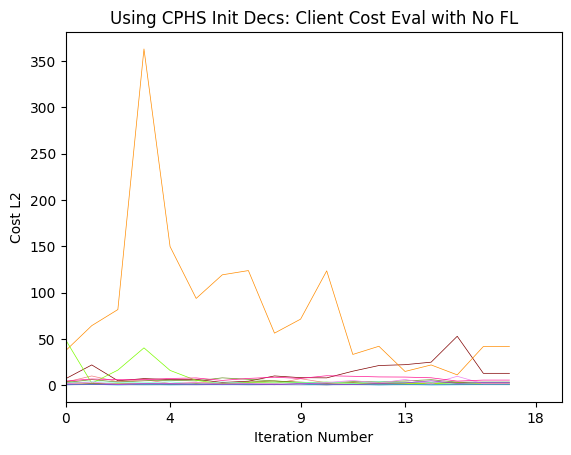

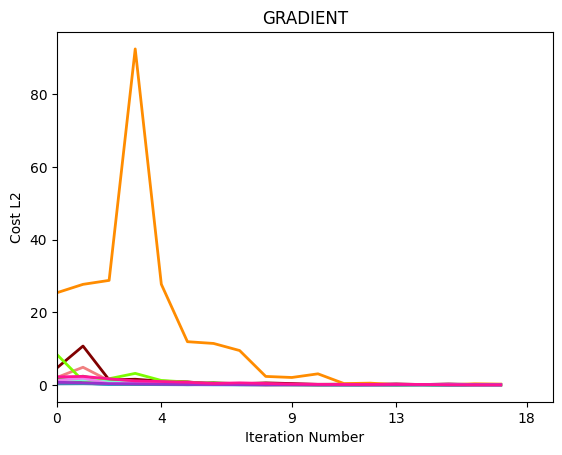

In [5]:
users_c1 = [Client(i, cond1b1_AllInitDecs_list[i], 'FullScipyMinStep', cond1b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_c1 = Server(-1, D_0, 'NoFL', users_c1, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_c1.execute_FL_loop()
    
condensed_external_plotting(users_c1, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')
condensed_external_plotting(users_c1, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

In [6]:
users_c2 = [Client(i, cond2b1_AllInitDecs_list[i], 'FullScipyMinStep', cond2b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=2, delay_scaling=0) for i in range(14)]
global_c2 = Server(-1, D_0, 'NoFL', users_c2, PCA_comps=64)

users_c3 = [Client(i, cond3b1_AllInitDecs_list[i], 'FullScipyMinStep', cond3b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=3, delay_scaling=0) for i in range(14)]
global_c3 = Server(-1, D_0, 'NoFL', users_c3, PCA_comps=64)

users_c4 = [Client(i, cond4b1_AllInitDecs_list[i], 'FullScipyMinStep', cond4b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=4, delay_scaling=0) for i in range(14)]
global_c4 = Server(-1, D_0, 'NoFL', users_c4, PCA_comps=64)

#users_c5 = [Client(i, cond5b1_AllInitDecs_list[i], 'FullScipyMinStep', cond5b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=5, delay_scaling=0) for i in range(14)]
#global_c5 = Server(-1, D_0, 'NoFL', users_c5, PCA_comps=64)
#
#users_c6 = [Client(i, cond6b1_AllInitDecs_list[i], 'FullScipyMinStep', cond6b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=6, delay_scaling=0) for i in range(14)]
#global_c6 = Server(-1, D_0, 'NoFL', users_c6, PCA_comps=64)
#
#users_c7 = [Client(i, cond7b1_AllInitDecs_list[i], 'FullScipyMinStep', cond7b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=7, delay_scaling=0) for i in range(14)]
#global_c7 = Server(-1, D_0, 'NoFL', users_c7, PCA_comps=64)
#
#users_c8 = [Client(i, cond8b1_AllInitDecs_list[i], 'FullScipyMinStep', cond8b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=8, delay_scaling=0) for i in range(14)]
#global_c8 = Server(-1, D_0, 'NoFL', users_c8, PCA_comps=64)

num_updates_left = 19
for i in range(num_updates_left):
    global_c2.execute_FL_loop()
    global_c3.execute_FL_loop()
    global_c4.execute_FL_loop()
    #global_c5.execute_FL_loop()
    #global_c6.execute_FL_loop()
    #global_c7.execute_FL_loop()
    #global_c8.execute_FL_loop()

In [7]:
t0 = time.time()

dec_flattened1 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened2 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened3 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened4 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
#dec_flattened5 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
#dec_flattened6 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
#dec_flattened7 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
#dec_flattened8 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
#my_cond = 1
for key_idx, key in enumerate(keys):
    for update_number, update_idx in enumerate(update_ix):
        dec_flattened1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1[key_idx].dec_log[update_number])]
        dec_flattened2.loc[len(dec_flattened2)] = [key, update_number, np.ravel(users_c2[key_idx].dec_log[update_number])]
        dec_flattened3.loc[len(dec_flattened3)] = [key, update_number, np.ravel(users_c3[key_idx].dec_log[update_number])]
        dec_flattened4.loc[len(dec_flattened4)] = [key, update_number, np.ravel(users_c4[key_idx].dec_log[update_number])]
        #dec_flattened5.loc[len(dec_flattened5)] = [key, update_number, np.ravel(users_c5[key_idx].dec_log[update_number])]
        #dec_flattened6.loc[len(dec_flattened6)] = [key, update_number, np.ravel(users_c6[key_idx].dec_log[update_number])]
        #dec_flattened7.loc[len(dec_flattened7)] = [key, update_number, np.ravel(users_c7[key_idx].dec_log[update_number])]
        #dec_flattened8.loc[len(dec_flattened8)] = [key, update_number, np.ravel(users_c8[key_idx].dec_log[update_number])]        
t1 = time.time()
total = t1-t0  
print(total)

# Concat all the dfs into a single training input dataframe
#dec_flattened = pd.concat([dec_flattened1, dec_flattened2, dec_flattened3, dec_flattened4, dec_flattened5, dec_flattened6, dec_flattened7, dec_flattened8], ignore_index=True, axis=0)
dec_flattened = pd.concat([dec_flattened1, dec_flattened2, dec_flattened3, dec_flattened4], ignore_index=True, axis=0)
#dec_flattened = pd.concat([dec_flattened1, dec_flattened2], ignore_index=True, axis=0)

# Take the keys (key_to_num for label) as label df
flat_dec_labels = pd.DataFrame(dec_flattened['Subject'].apply(lambda x: key_to_num[x]))

print(dec_flattened.shape)
display(dec_flattened.head())
display(flat_dec_labels.head())

2.3333239555358887
(1064, 3)


,Subject,Update Number,Flattened Dec
0,METACPHS_S106,0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,METACPHS_S106,1,"[0.0012428571820445565, 0.0024633951054546075,..."
2,METACPHS_S106,2,"[-0.000371724305927257, 0.0038102187891554022,..."
3,METACPHS_S106,3,"[0.0010092753071342287, 0.002854765643709487, ..."
4,METACPHS_S106,4,"[-0.00017400101870417093, 0.001306007950389139..."


,Subject
0,0
1,0
2,0
3,0
4,0


In [8]:
lists = [list(range(x, x+4)) for x in (3,4,5,6)]
lists

[[3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9]]

In [9]:
df = pd.DataFrame({'A': [3,4,5,6], 'B': lists})
df.head(100)

,A,B
0,3,"[3, 4, 5, 6]"
1,4,"[4, 5, 6, 7]"
2,5,"[5, 6, 7, 8]"
3,6,"[6, 7, 8, 9]"


In [10]:
df['B'].apply(pd.Series).add_prefix('col_')
df.head(100)

,A,B
0,3,"[3, 4, 5, 6]"
1,4,"[4, 5, 6, 7]"
2,5,"[5, 6, 7, 8]"
3,6,"[6, 7, 8, 9]"


In [11]:
df2 = df.drop(columns=['B']).join(df['B'].apply(pd.Series).add_prefix('col_'))
df2.head(100)

,A,col_0,col_1,col_2,col_3
0,3,3,4,5,6
1,4,4,5,6,7
2,5,5,6,7,8
3,6,6,7,8,9


In [12]:
dec_flattened.head()

,Subject,Update Number,Flattened Dec
0,METACPHS_S106,0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,METACPHS_S106,1,"[0.0012428571820445565, 0.0024633951054546075,..."
2,METACPHS_S106,2,"[-0.000371724305927257, 0.0038102187891554022,..."
3,METACPHS_S106,3,"[0.0010092753071342287, 0.002854765643709487, ..."
4,METACPHS_S106,4,"[-0.00017400101870417093, 0.001306007950389139..."


In [17]:
dec_flattened2 = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series).add_prefix('col_'))
dec_flattened2.head()

MemoryError: Unable to allocate 20.3 MiB for an array with shape (2658560,) and data type int64

In [13]:
num_dps = 4

rounded_df = pd.DataFrame(dec_flattened['Flattened Dec']).apply(lambda x: [np.round(ele, num_dps) for ele in x])
rounded_df.head()

,Flattened Dec
0,"[0.0027, 0.0026, 0.0031, 0.0096, 0.0095, 0.004..."
1,"[0.0012, 0.0025, 0.0005, 0.0067, 0.003, 0.0005..."
2,"[-0.0004, 0.0038, -0.0001, 0.0057, 0.0009, -0...."
3,"[0.001, 0.0029, -0.0001, 0.0052, -0.0022, -0.0..."
4,"[-0.0002, 0.0013, -0.0012, 0.0049, -0.0018, -0..."


In [14]:
dec_flattened2 = rounded_df.join(rounded_df['Flattened Dec'].apply(pd.Series))#.add_prefix('col_'))
dec_flattened2.head()

MemoryError: Unable to allocate 20.3 MiB for an array with shape (2658560,) and data type int64

In [ ]:
num_dps = 4

rounded_df = pd.DataFrame(dec_flattened['Flattened Dec']).apply(lambda x: [np.round(ele, num_dps) for ele in x])
rounded_df.head()

########################################################################################################

expanded_dec_df = pd.DataFrame()

# Break up list so that every element is its own cell (col)
for my_row in range(rounded_df.shape[0]):
    test=pd.DataFrame(rounded_df.iloc[my_row,0]).T
    expanded_dec_df = pd.concat((expanded_dec_df, test))
expanded_dec_df.reset_index(inplace=True, drop=True)
expanded_dec_df.insert(loc=0, column='Update Number', value=list(dec_flattened['Update Number']))
#expanded_dec_df.insert(loc=0, column='Condition', value=list(dec_flattened['Condition']))
expanded_dec_df.insert(loc=0, column='Subject', value=list(dec_flattened['Subject']))
    
print(expanded_dec_df.shape)
expanded_dec_df.head()

In [ ]:
expanded_dec_df = pd.DataFrame()

# Break up list so that every element is its own cell (col)
for my_row in range(dec_flattened.shape[0]):
    test=pd.DataFrame(dec_flattened.iloc[my_row,2]).T
    expanded_dec_df = pd.concat((expanded_dec_df, test))
expanded_dec_df.reset_index(inplace=True, drop=True)
expanded_dec_df.insert(loc=0, column='Update Number', value=list(dec_flattened['Update Number']))
#expanded_dec_df.insert(loc=0, column='Condition', value=list(dec_flattened['Condition']))
expanded_dec_df.insert(loc=0, column='Subject', value=list(dec_flattened['Subject']))
    
print(expanded_dec_df.shape)
expanded_dec_df.head()

In [ ]:
assert(np.sum(expanded_dec_df.isnull().values)==0)

# Adversarial Model Stuff

In [ ]:
#my_models = [LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier()]
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

# Concat All 19 Update Model Results
> Should I be trying to use the same model but predicting on different datasets too?

In [ ]:
def make_all_update_models(flattened_input_df, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    for i in range(19):
        print(f"{i} of {19}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [ ]:
full_test_df = make_all_update_models(expanded_dec_df)
full_test_df.head(8)

## Plot Accuracy As a Func of N

In [ ]:
pos_lr_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LogisticRegression()']
pos_knn_df = full_pos_test_df[full_pos_test_df['Algorithm']=='KNeighborsClassifier()']
pos_svc_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LinearSVC()']
pos_sgd_df = full_pos_test_df[full_pos_test_df['Algorithm']=='SGDClassifier()']
pos_dt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='DecisionTreeClassifier()']
pos_gbt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='GradientBoostingClassifier()']

In [ ]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, pos_lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, pos_knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, pos_svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, pos_sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, pos_dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, pos_gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('POSITIVE INIT: Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

In [ ]:
neg_lr_df = full_neg_test_df[full_neg_test_df['Algorithm']=='LogisticRegression()']
neg_knn_df = full_neg_test_df[full_neg_test_df['Algorithm']=='KNeighborsClassifier()']
neg_svc_df = full_neg_test_df[full_neg_test_df['Algorithm']=='LinearSVC()']
neg_sgd_df = full_neg_test_df[full_neg_test_df['Algorithm']=='SGDClassifier()']
neg_dt_df = full_neg_test_df[full_neg_test_df['Algorithm']=='DecisionTreeClassifier()']
neg_gbt_df = full_neg_test_df[full_neg_test_df['Algorithm']=='GradientBoostingClassifier()']

In [ ]:
neg_gbt_df.head()

Now plot for negative init case

In [ ]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, neg_lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, neg_knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, neg_svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, neg_sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, neg_dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, neg_gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('NEGATIVE INIT: Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

Accuracies get considerably worse.  From the original (NB 104), we had the following:
- SVC: 80
- LR: 70
- KNN: 57
- GBC: 53
- DTree: 38

However, this is of course a caveat here: when we split the data into the pos and neg condition dfs, we therefore trained the models with half as much data as they otherwise wouldv'e had (as compared to NB 104 for instance which had the entire dataset to train on).  So let's rerun the NB 104 code using just a random 50% of the full data

In [ ]:
# Shuffle the DF
full_dec_df = pd.concat((neg_dec_expanded_df, neg_dec_expanded_df))
shuffled_dec_df = full_dec_df.sample(frac=1)
print(shuffled_dec_df.shape)
shuffled_dec_df.head()

In [ ]:
half_df = shuffled_dec_df.iloc[shuffled_dec_df.shape[0]//2:, :]
print(half_df.shape)
half_df.head()

In [ ]:
half_df, half_test_df = nth_decoder_model(half_df, 18, my_models, test=True)
half_test_df.head(100)

In [ ]:
half_test_df.iloc[:, 2]

When comparing to the test accuracies all the graphs and testing dataframes, notice that this final performance is actually still better for all models, which was unexpected (especially for KNN!).  E.g. we observe that splitting into positive and negative conditions (initializations) does NOT actually improve the capabilities of an adverary, as the adversary's ML model performs better when just a random sample of all data is taken.
> A smaller caveat here is that we only tested one random sample of the data, so perhaps this was just a "good" initialization of random training data

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(dec_flattened, flat_dec_labels)
y_train = np.ravel(y_train)

print(f"Original dataset shape: {dec_flattened.shape}")
print(f"X_train shape: {X_train.shape}")
X_train.head()

X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()

# Break up list so that every element is its own cell
for my_row in range(X_train.shape[0]):
    test=pd.DataFrame(X_train.iloc[my_row,2]).T
    X_train2 = pd.concat((X_train2, test))
    
for my_row in range(X_test.shape[0]):
    test=pd.DataFrame(X_test.iloc[my_row,2]).T
    X_test2 = pd.concat((X_test2, test))
    
# Convert from strings to floats... not sure if this matters
X_train = X_train2.apply(pd.to_numeric)
X_test = X_test2.apply(pd.to_numeric)
    
X_train.head()

In [ ]:
## 1 Scipy Step

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_1scipystep, 'global', show_update_change=False, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='DRF=1[Off]: GRADIENT')